In [1]:
import zipfile
import os

zip_file = "/content/folder.zip"
os.makedirs('extracted_files', exist_ok=True)

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')


In [2]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T

class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])
        self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")

        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        boxes = []
        labels = []

        with open(label_path) as f:
            for line in f.readlines():
                class_id, x_center, y_center, width, height = map(float, line.strip().split())

                img_w, img_h = img.size
                x_min = (x_center - width / 2) * img_w
                y_min = (y_center - height / 2) * img_h
                x_max = (x_center + width / 2) * img_w
                y_max = (y_center + height / 2) * img_h

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms:
            img = self.transforms(img)

        return img, target

transform = T.Compose([T.ToTensor()])


In [3]:
from torch.utils.data import DataLoader

train_images_dir = "/content/extracted_files/kaggle/working/dataset/train/images"
train_labels_dir = "/content/extracted_files/kaggle/working/dataset/train/labels"
val_images_dir = "/content/extracted_files/kaggle/working/dataset/val/images"
val_labels_dir = "/content/extracted_files/kaggle/working/dataset/val/labels"

train_dataset = CustomDataset(train_images_dir, train_labels_dir, transforms=transform)
val_dataset = CustomDataset(val_images_dir, val_labels_dir, transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [10]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 6
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [11]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item():.4f}")


Epoch [1/10], Loss: 0.8550
Epoch [2/10], Loss: 0.7806
Epoch [3/10], Loss: 0.8610
Epoch [4/10], Loss: 0.5986
Epoch [5/10], Loss: 0.7119
Epoch [6/10], Loss: 0.6218
Epoch [7/10], Loss: 0.6942
Epoch [8/10], Loss: 0.7097
Epoch [9/10], Loss: 0.4736
Epoch [10/10], Loss: 0.5030


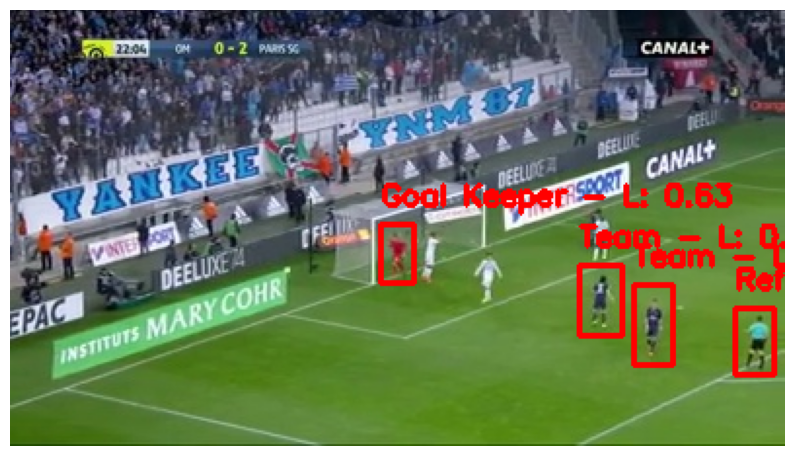

In [15]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as T

model.eval()
transform = T.Compose([T.ToTensor()])

def predict(model, image_path, threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        predictions = model(image_tensor)

    pred_boxes = predictions[0]['boxes'].cpu().numpy()
    pred_scores = predictions[0]['scores'].cpu().numpy()
    pred_labels = predictions[0]['labels'].cpu().numpy()

    valid_boxes = pred_boxes[pred_scores >= threshold]
    valid_scores = pred_scores[pred_scores >= threshold]
    valid_labels = pred_labels[pred_scores >= threshold]

    return valid_boxes, valid_scores, valid_labels

def visualize_predictions(image_path, boxes, labels, scores, class_names):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for i, (box, score, label) in enumerate(zip(boxes, scores, labels)):
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        label_text = f"{class_names[label]}: {score:.2f}"
        cv2.putText(image, label_text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

class_names = ["background", "Team - L", "Goal Keeper - L", "Goal Keeper - R", "Refree", "Team - R"]

image_path = "/content/frame_33125.jpg"

boxes, scores, labels = predict(model, image_path, threshold=0.5)
visualize_predictions(image_path, boxes, labels, scores, class_names)
